# Liability hedging portfolios

In [19]:
import pandas as pd, numpy as np
import edhec_risk_kit as erk
import ipywidgets as widgets
from IPython.display import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
erk.discount(10, 0.03)

0.7440939148967249

In [84]:
liabilities = pd.Series([1, 1.5, 2, 2.5], index=[3,3.5,4,4.5])

In [85]:
erk.pv(liabilities, 0.03)

6.233320315080044

In [86]:
erk.funding_ratio(5, liabilities, 0.02)

0.7720304366941647

In [87]:
def show_funding_ratio(assets, r):
    fr = erk.funding_ratio(assets, liabilities, r)
    print(f'{fr*100:.2f}')
    
controls = widgets.interactive(show_funding_ratio,
                             assets = widgets.IntSlider(min=1, max=10, step=1, value=5),
                             r = (0, 0.20, 0.01))

display(controls)

interactive(children=(IntSlider(value=5, description='assets', max=10, min=1), FloatSlider(value=0.1, descript…

# CIR (Cox Ingersoil Ross) Model

$dr_t = a(b-r_t)dt+\sigma \sqrt{r_t} dW_t$

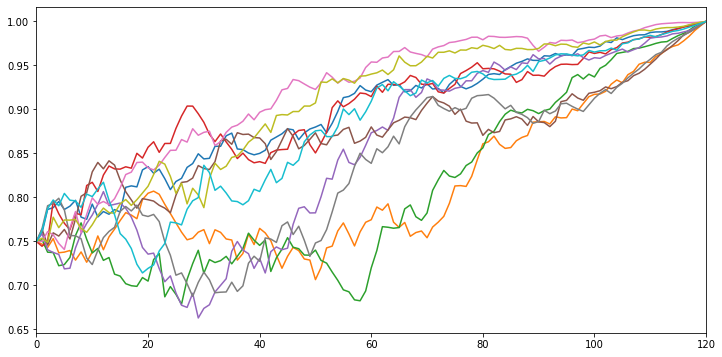

In [88]:
erk.cir(n_scenarios = 10)[1].plot(figsize=(12, 6), legend=False)

In [89]:
controls = widgets.interactive(erk.show_cir_prices,
                               n_years = widgets.IntSlider(min=1, max=20, step=1, value=12), 
                               n_scenarios= (1, 50, 1), 
                               #a = (0, 1, 0.01),
                               a = widgets.FloatSlider(value=0.05, min=0.0, max=1.0, step=0.01, description="Rate of mean reversion"), 
                               b = widgets.FloatSlider(value=0.03, min=0.0, max=0.1,step= 0.01, description="Long term int rate"),
                               sigma = (0, 0.5, 0.01),
                               steps_per_year = widgets.IntSlider(min=1, max=12, step=1, value=12),
                               r_0 = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.03))

display(controls)

interactive(children=(IntSlider(value=12, description='n_years', max=20, min=1), IntSlider(value=1, descriptio…

In [103]:
a_0 = 0.75  # Initial amount of wealth
rates, bond_prices = erk.cir(n_years=10, r_0=0.03, b=0.03, n_scenarios=10)
liabilities = bond_prices
zc_bond_10 = pd.Series(data=[1], index=[10])
zc_0 = erk.pv(zc_bond_10, r=0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices  # av = asset value
av_cash = a_0*(rates/12+1).cumprod()



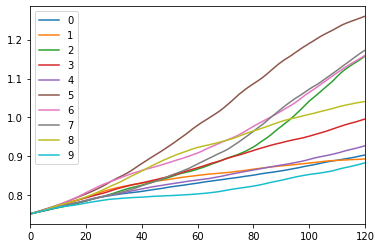

In [95]:
av_cash.plot()

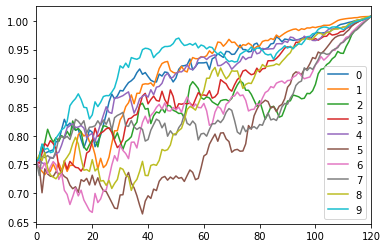

In [96]:
av_zc_bonds.plot()

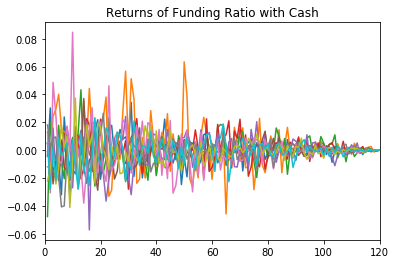

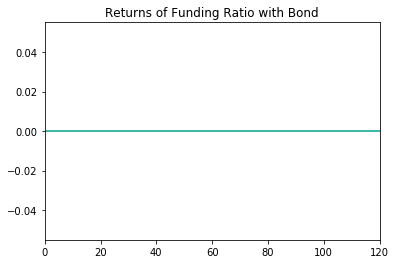

In [106]:
(av_cash/liabilities).pct_change().plot(title="Returns of Funding Ratio with Cash", legend=False)
(av_zc_bonds/liabilities).pct_change().plot(title="Returns of Funding Ratio with Bond", legend=False)

In [107]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0=0.03, b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zc_bond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds * bond_prices
av_cash = a_0 * (rates/12+1).cumprod()

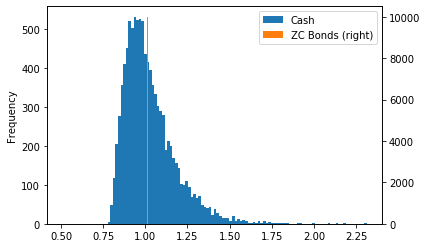

In [113]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]  # Terminal funding ratio
tfr_zc_bonds= av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax = tfr_cash.plot.hist(label='Cash', bins=100, legend=True)
tfr_zc_bonds.plot.hist(ax=ax, label="ZC Bonds", bins=100, legend=True, secondary_y=True)

# GHP Construction with Duration Matching

In [124]:
erk.bond_price(10)

100.00000000000057

In [125]:
erk.bond_cash_flows(3, 100, 0.03, 2)

1      1.5
2      1.5
3      1.5
4      1.5
5      1.5
6    101.5
dtype: float64

In [126]:
rates = np.linspace(0.01, .10, num=20)
rates

array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ])

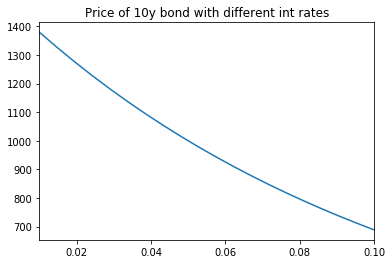

In [131]:
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(title="Price of 10y bond with different int rates", legend=False)

In [142]:
cf = erk.bond_cash_flows(3, 1000, 0.06, 2)
discounts = erk.discount(cf.index, 0.06/2)
dcf = discounts*cf
(dcf/dcf.sum()*cf.index).sum()/2

2.789853593597267

2.789853593597267

In [145]:
macaulay_duration(erk.bond_cash_flows(3, 1000, 0.06, 2), 0.06/2, 2)

2.789853593597267

In [147]:
liabilities = pd.Series(data=[100000, 100000], index=[10,12])
erk.macaulay_duration(liabilities, .04, 1)

AttributeError: module 'edhec_risk_kit' has no attribute 'macaulay_duration'

(10.960799385088393, 13.544718122145921, 8.190898824083233)

In [159]:
short_bond = erk.bond_cash_flows(10, 1000, 0.05, 1)
long_bond = erk.bond_cash_flows(20, 1000, 0.05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [163]:
p_short = erk.bond_price(10, 1000, 0.05, 1, 0.04)
p_long = erk.bond_price(20, 1000, 0.05, 1, 0.04)
a_0 = 130000
p_flows = pd.concat([a_0*w_s/p_short*short_bond,a_0*(1-w_s)/p_long*long_bond])
erk.macaulay_duration(p_flows, 0.04)

10.960799385088393

In [168]:
cfr = erk.funding_ratio(p_flows, liabilities, 0.04)  # Cash funding ratio
cfr

0.9998760012192478

In [170]:
np.linspace(0, 0.1, 20)
lb_assets = a_0*long_bond/p_long
sb_assets = a_0*short_bond/p_short

fr_change = pd.DataFrame({
    "Long Bond": [erk.funding_ratio(lb_assets, liabilities, r) for r in rates], 
    "Short Bond": [erk.funding_ratio(sb_assets, liabilities, r) for r in rates], 
    "Duration Matched Bonds": [erk.funding_ratio(p_flows, liabilities, r) for r in rates], 
})

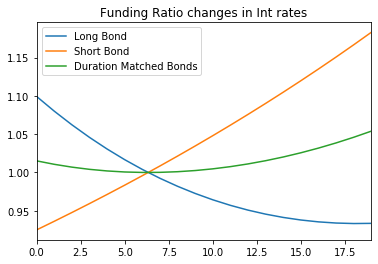

In [172]:
fr_change.plot(title="Funding Ratio changes in Int rates")